In [204]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [206]:
file_path = 'taxi_dataset.csv'
data = pd.read_csv(file_path)

In [207]:
# clean dataset
data.columns = data.iloc[0]
data = data[1:]
data.reset_index(drop=True, inplace=True)

In [208]:
# convert columns to appropriate data types
data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'], errors='coerce')
data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'], errors='coerce')


In [209]:
numeric_columns = [
    'passenger_count', 'trip_distance', 'pickup_longitude', 'pickup_latitude',
    'dropoff_longitude', 'dropoff_latitude', 'fare_amount', 'extra',
    'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount'
]


In [210]:
for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

In [211]:
# drop rows with missing values
data = data.dropna(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'fare_amount'])

In [212]:
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2998 entries, 0 to 2997
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               2998 non-null   object        
 1   tpep_pickup_datetime   2998 non-null   datetime64[ns]
 2   tpep_dropoff_datetime  2998 non-null   datetime64[ns]
 3   passenger_count        2998 non-null   int64         
 4   trip_distance          2998 non-null   float64       
 5   pickup_longitude       2998 non-null   float64       
 6   pickup_latitude        2998 non-null   float64       
 7   RateCodeID             2998 non-null   object        
 8   store_and_fwd_flag     2998 non-null   object        
 9   dropoff_longitude      2998 non-null   float64       
 10  dropoff_latitude       2998 non-null   float64       
 11  payment_type           2998 non-null   object        
 12  fare_amount            2998 non-null   float64       
 13  ext

In [230]:
# feature engineering
data['pickup_hour'] = data['tpep_pickup_datetime'].dt.hour
data['day_of_week'] = data['tpep_pickup_datetime'].dt.dayofweek


In [213]:
# define holiday dates and add feature
holidays = [
    "2015-01-01",  # New Year's Day
    "2015-07-04",  # Independence Day
    "2015-11-26",  # Thanksgiving
    "2015-12-25",  # Christmas
    "2015-12-31",  # New Year's Eve
]

In [214]:
holidays = [datetime.strptime(date, "%Y-%m-%d") for date in holidays]
data['is_holiday'] = data['tpep_pickup_datetime'].dt.date.isin([holiday.date() for holiday in holidays]).astype(int)

In [16]:
# prepare features for clustering
features = data[['pickup_hour', 'day_of_week', 'trip_distance', 'total_amount', 'is_holiday']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [215]:
# silhouette analysis 
silhouette_scores = []
k_values = range(2, 11)

In [220]:
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(features_scaled)
    silhouette_avg = silhouette_score(features_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

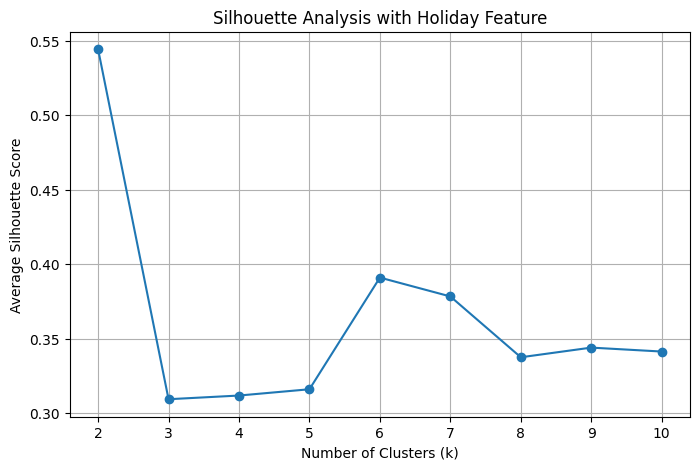

In [219]:
# plot silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Analysis with Holiday Feature')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.grid(True)
plt.show()

In [221]:
optimal_k = k_values[silhouette_scores.index(max(silhouette_scores))]

kmeans = KMeans(n_clusters=optimal_k, random_state=42)

data['cluster'] = kmeans.fit_predict(features_scaled)

In [231]:
print(f"Optimal number of clusters: {optimal_k}")
print("Cluster Centers with Holiday Feature:\n", kmeans.cluster_centers_)
print("\nCluster Summaries:")
print(data.groupby('cluster')[['pickup_hour', 'day_of_week', 'trip_distance', 'total_amount', 'is_holiday']].describe())

Optimal number of clusters: 2
Cluster Centers with Holiday Feature:
 [[ 0.06196925  0.00525288 -0.26143141 -0.25197835 -0.1500341 ]
 [-0.4860656  -0.04120177  2.05057851  1.97643199  1.17681616]]

Cluster Summaries:
0       pickup_hour                                                    \
              count       mean       std  min   25%   50%   75%   max   
cluster                                                                 
0            2659.0  15.376457  6.180754  0.0  11.0  17.0  20.0  23.0   
1             339.0  11.843658  7.554284  0.0   6.0  12.0  19.0  23.0   

0       day_of_week            ... total_amount         is_holiday           \
              count      mean  ...          75%     max      count     mean   
cluster                        ...                                            
0            2659.0  3.075592  ...        14.75   50.80     2659.0  0.00000   
1             339.0  2.994100  ...        49.74  205.05      339.0  0.19469   

0                     

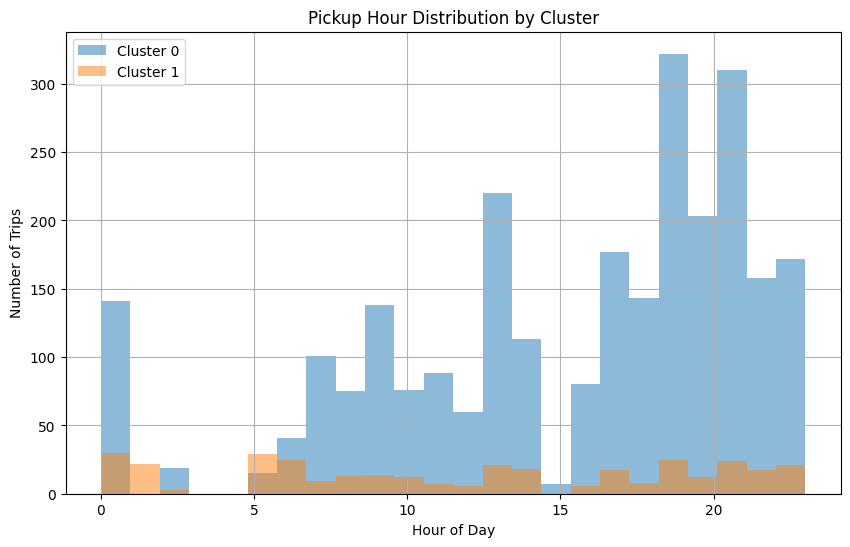

In [233]:
# plot histogram of pickup hours by cluster
plt.figure(figsize=(10, 6))
for cluster in data['cluster'].unique():
    subset = data[data['cluster'] == cluster]
    plt.hist(subset['pickup_hour'], bins=24, alpha=0.5, label=f'Cluster {cluster}')

plt.title('Pickup Hour Distribution by Cluster')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.legend()
plt.grid(True)
plt.show()

In [234]:
grouped = data.groupby(['day_of_week', 'cluster']).size().unstack()

In [235]:
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
grouped.index = [day_names[day] for day in grouped.index]

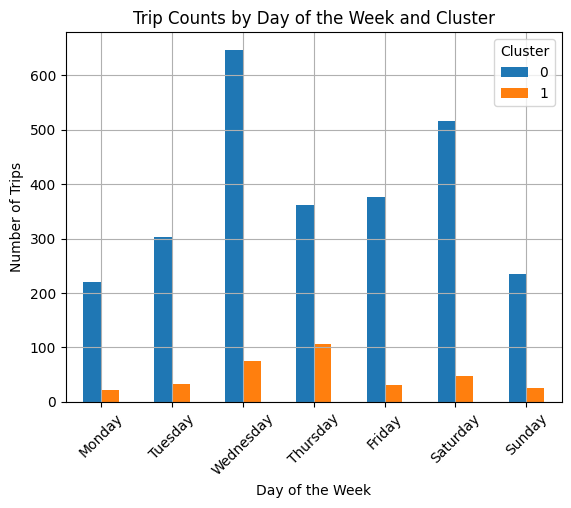

In [236]:
# bar plot
grouped.plot(kind='bar')
plt.title('Trip Counts by Day of the Week and Cluster')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.legend(title='Cluster')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [239]:
# normalize relevant features
features = ['trip_distance', 'passenger_count', 'fare_amount', 'pickup_hour', 'day_of_week']
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data[features]), columns=features)

In [238]:
# define query trips
query_trips = pd.DataFrame(
    [
        [10, 4, 50, 18, 5],  # High-demand trip
        [2, 1, 10, 6, 2],    # Low-demand trip
        [8, 2, 35, 12, 6]    # Holiday-specific trip
    ],
    columns=['trip_distance', 'passenger_count', 'fare_amount', 'pickup_hour', 'day_of_week']
)

In [240]:
# Scale query trips 
queries_scaled = scaler.transform(queries)

/Users/sarah/miniconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [243]:
similarities = []
for query_scaled in queries_scaled:
    query_scaled = query_scaled.reshape(1, -1) 
    similarity = cosine_similarity(query_scaled, data_scaled)
    similarities.append(np.argsort(-similarity[0])[:10])  
    

In [244]:
# print top 10 similar trips for each query
for idx, trips in enumerate(similarities):
    print(f"Top 10 trips similar to Query {idx + 1}:")
    print(data.iloc[trips])

Top 10 trips similar to Query 1:
0    VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
2929        2  2015-01-10 17:20:12   2015-01-10 18:07:01                5   
2188        2  2015-01-10 21:34:50   2015-01-10 22:07:25                5   
84          2  2015-01-15 14:00:43   2015-01-15 14:41:50                3   
1784        2  2015-01-22 17:38:54   2015-01-22 18:06:38                2   
2991        1  2015-01-15 15:47:38   2015-01-15 16:13:56                2   
2388        2  2015-01-22 19:48:33   2015-01-22 20:20:34                4   
318         1  2015-01-17 23:39:58   2015-01-18 00:10:08                3   
8           1  2015-01-10 20:33:39   2015-01-10 21:11:35                3   
2662        2  2015-01-10 21:40:35   2015-01-10 22:11:50                2   
1731        2  2015-01-24 08:31:46   2015-01-24 09:10:26                6   

0     trip_distance  pickup_longitude  pickup_latitude RateCodeID  \
2929          18.28        -73.983429        40.75

In [245]:
top_10_indices = np.argsort(-similarity[0])[:10]
top_10_trips = data.iloc[top_10_indices]

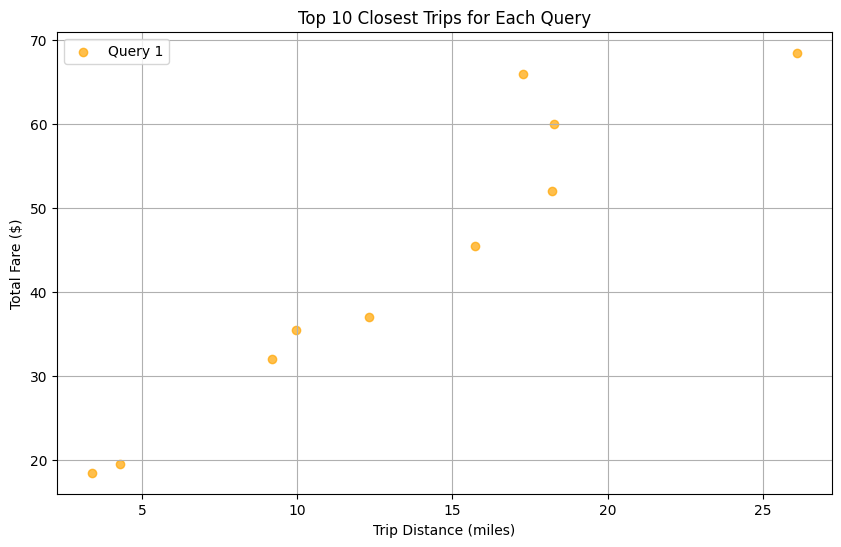

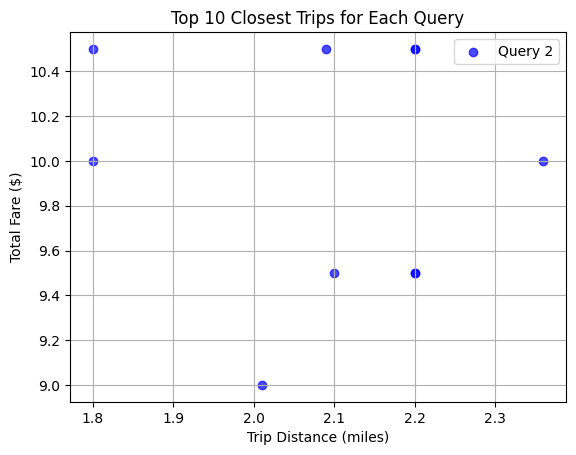

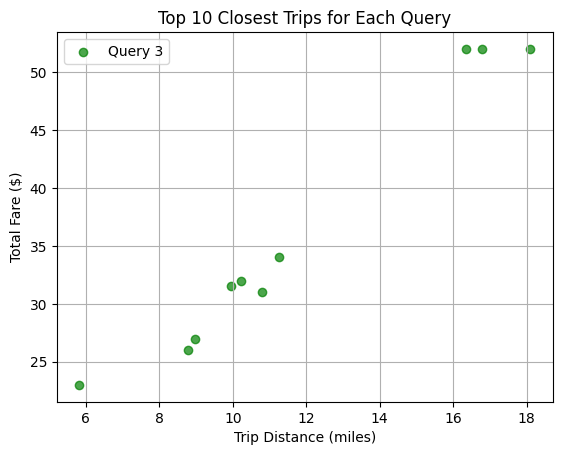

In [246]:
plt.figure(figsize=(10, 6))
colors = ['orange', 'blue', 'green']

# plot top 10 trips for each query
for i, top_10_indices in enumerate(similarities):
    top_10_trips = data.iloc[top_10_indices]
    
    plt.scatter(
        top_10_trips['trip_distance'],
        top_10_trips['fare_amount'],
        color=colors[i],
        alpha=0.7,
        label=f'Query {i + 1}')
    plt.title('Top 10 Closest Trips for Each Query',)
    plt.xlabel('Trip Distance (miles)')
    plt.ylabel('Total Fare ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [247]:
# Create trip_duration
data['trip_duration'] = (data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']).dt.total_seconds() / 60

In [248]:
# Rush hour (7-10 AM, 4-8 PM)
data['rush_hour'] = data['tpep_pickup_datetime'].dt.hour.apply(
    lambda x: 1 if (7 <= x <= 10) or (16 <= x <= 20) else 0)

In [249]:
# Create bins for trip distance
data['distance_bin'] = pd.cut(data['trip_distance'], bins=[0, 2, 5, 10, 20, np.inf], 
                              labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long'])


In [251]:
# airport based on coordinate ranges
def is_airport_trip(lat, lon):
    """Identify if a trip is near JFK or LaGuardia airports based on latitude/longitude."""
    jfk_coords = (-73.78, 40.64)  # JFK coordinates
    lga_coords = (-73.87, 40.77)  # LaGuardia coordinates
    if np.isclose(lon, jfk_coords[0], atol=0.1) or np.isclose(lon, lga_coords[0], atol=0.1):
        return 1
    return 0

data['airport_flag'] = data.apply(
    lambda row: is_airport_trip(row['pickup_latitude'], row['pickup_longitude']), axis=1
)

In [252]:
# features and target variable
features = ['trip_distance', 'pickup_hour', 'day_of_week', 'passenger_count', 'is_holiday']
target = 'fare_amount'

In [253]:
# day type (weekday, weekend, holiday)
data['day_of_week'] = data['tpep_pickup_datetime'].dt.dayofweek
data['day_type'] = data['day_of_week'].apply(
    lambda x: 'Weekend' if x in [5, 6] else 'Weekday'
)
data.loc[data['is_holiday'] == 1, 'day_type'] = 'Holiday'


In [254]:
print(data.info())
print(data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2998 entries, 0 to 2997
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               2998 non-null   object        
 1   tpep_pickup_datetime   2998 non-null   datetime64[ns]
 2   tpep_dropoff_datetime  2998 non-null   datetime64[ns]
 3   passenger_count        2998 non-null   int64         
 4   trip_distance          2998 non-null   float64       
 5   pickup_longitude       2998 non-null   float64       
 6   pickup_latitude        2998 non-null   float64       
 7   RateCodeID             2998 non-null   object        
 8   store_and_fwd_flag     2998 non-null   object        
 9   dropoff_longitude      2998 non-null   float64       
 10  dropoff_latitude       2998 non-null   float64       
 11  payment_type           2998 non-null   object        
 12  fare_amount            2998 non-null   float64       
 13  ext

In [256]:
# define target variable and features
target = 'fare_amount'
features = [
    'trip_distance', 'trip_duration', 'rush_hour', 'airport_flag',
    'day_of_week','day_type_Weekend', 'is_holiday']

In [255]:
data = data.dropna(subset=[target])
X = data[features]
y = data[target]

In [257]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [258]:
# train and predict Random Forest 
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

In [259]:
# model performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

Mean Squared Error (MSE): 31.38
Mean Absolute Error (MAE): 1.71


In [261]:
# feature importance
importances = rf_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

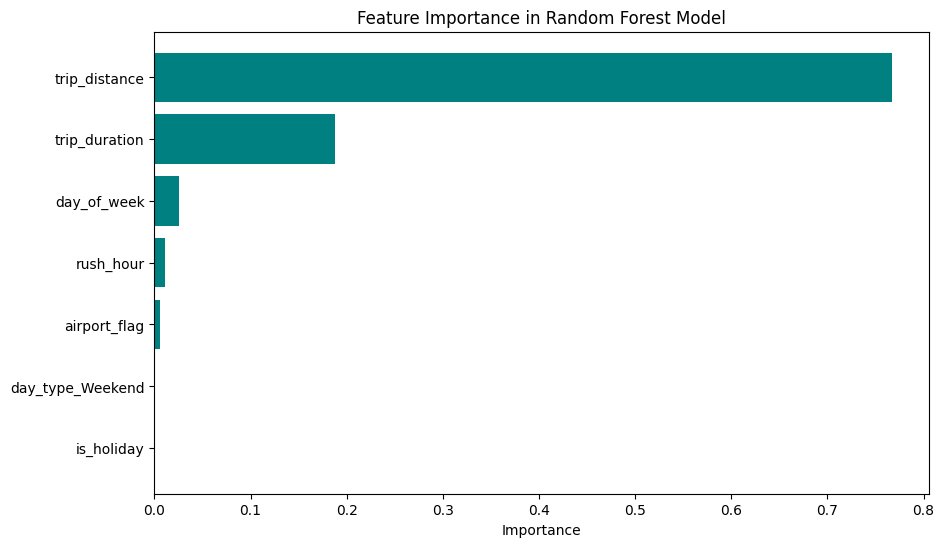

In [260]:
# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='teal')
plt.gca().invert_yaxis()
plt.title('Feature Importance in Random Forest Model')
plt.xlabel('Importance')
plt.show()


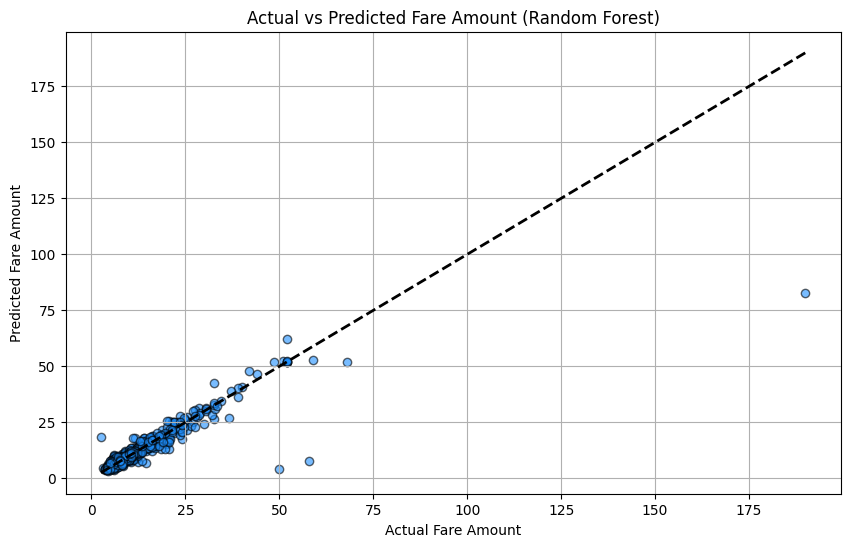

In [267]:
# plot actual vs predicted fare amount
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='dodgerblue', alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', linewidth=2)
plt.title('Actual vs Predicted Fare Amount (Random Forest)')
plt.xlabel('Actual Fare Amount')
plt.ylabel('Predicted Fare Amount')
plt.grid(True)
plt.show()

In [263]:
y_pred = rf_model.predict(X_test)

In [264]:
residuals = y_test - y_pred

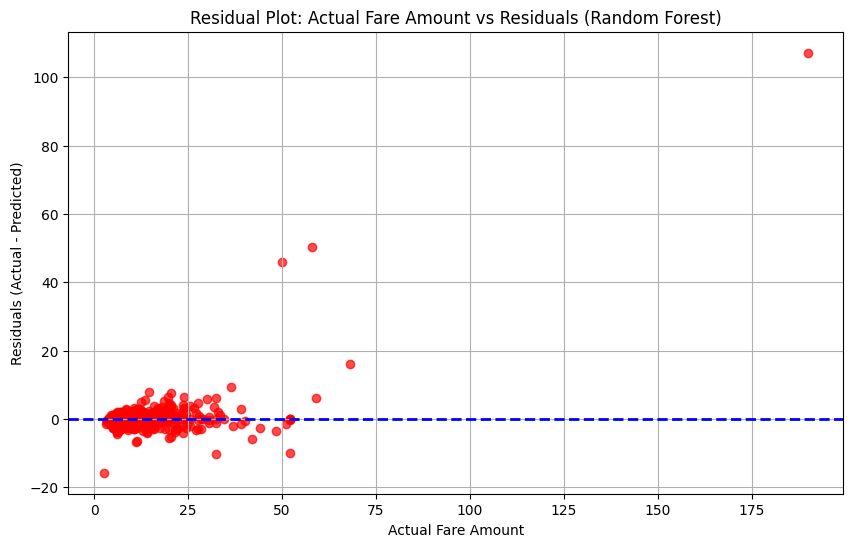

In [265]:
# plot the residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, color='red', alpha=0.7)
plt.axhline(0, color='blue', linestyle='--', linewidth=2)
plt.title('Residual Plot: Actual Fare Amount vs Residuals (Random Forest)')
plt.xlabel('Actual Fare Amount')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True)
plt.show()